**1. Data Preparation**

**Step 1.1: Load and Prepare Data**

In [ ]:
import pandas as pd

# Load datasets
customers = pd.read_csv('/content/Customers.csv')
transactions = pd.read_csv('/content/Transactions.csv')

# Convert date columns to datetime
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

# Aggregate transaction data by CustomerID
transaction_data = transactions.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum'
}).reset_index()

# Merge datasets
data = pd.merge(customers, transaction_data, on='CustomerID')



**2. Feature Engineering**

**Step 2.1: Select Features**

In [ ]:
# Select features for clustering
features = data[['TotalValue', 'Quantity', 'SignupDate']].copy()

# Explicitly cast the 'SignupDate' to a float compatible dtype
features['SignupDate'] = features['SignupDate'].astype('datetime64[ns]')

# Calculate the days since the minimum SignupDate
features['SignupDate'] = (features['SignupDate'] - features['SignupDate'].min()).dt.days



**Scaling the Features**

**Step 3.1: Scale Features**

In [ ]:
from sklearn.preprocessing import StandardScaler

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


**Applying K-Means Clustering**

**Step 3.2: Apply K-Means Clustering**

In [ ]:
from sklearn.cluster import KMeans

# Apply K-Means clustering with k=5 (choose between 2 and 10)
kmeans = KMeans(n_clusters=5, random_state=42)
data['Cluster'] = kmeans.fit_predict(scaled_features)


**Calculating Clustering Metrics**

**Step 4.1: Calculate Davies-Bouldin Index**

In [ ]:
from sklearn.metrics import davies_bouldin_score

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(scaled_features, data['Cluster'])
print('DB Index:', db_index)


DB Index: 0.9344500774507883


In [ ]:
from sklearn.metrics import silhouette_score

# Calculate the silhouette score
silhouette_avg = silhouette_score(scaled_features, data['Cluster'])
print('Silhouette Score:', silhouette_avg)


Silhouette Score: 0.3221539961837519


In [ ]:
# Calculate the WCSS
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

print('WCSS for each k:', wcss)


WCSS for each k: [597.0000000000001, 346.6724462401302, 238.90579183627435, 186.57672834998087, 158.6801917739819, 133.9805098110021, 108.33016904701638, 100.73157565124612, 88.00127003049502, 83.61839849863799]


**Visualizing Clusters**

**Step 5.1: Visualize Clusters**

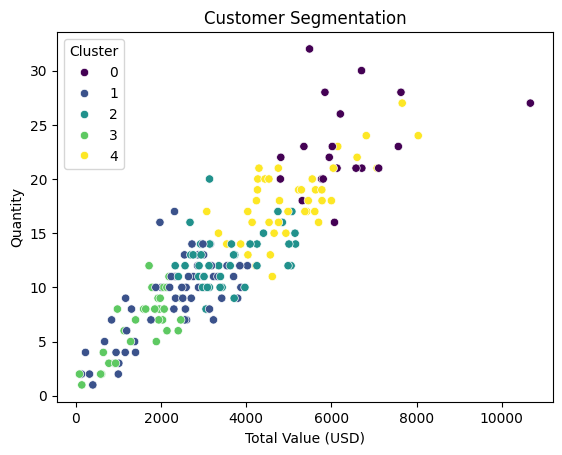

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot of clusters
sns.scatterplot(x='TotalValue', y='Quantity', hue='Cluster', data=data, palette='viridis')
plt.title('Customer Segmentation')
plt.xlabel('Total Value (USD)')
plt.ylabel('Quantity')
plt.show()




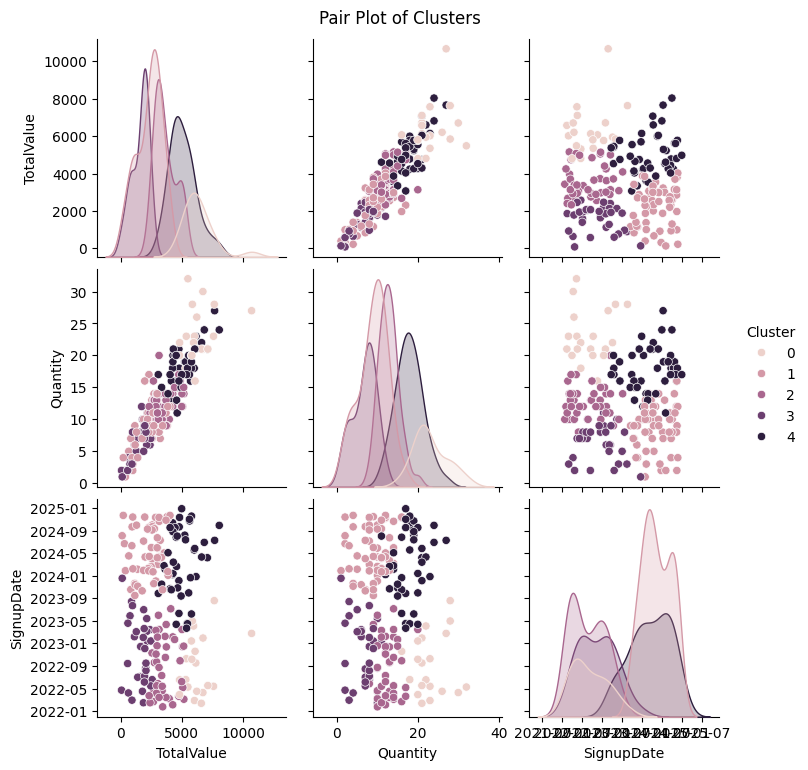

In [ ]:
# Pair plot to visualize clusters across all features
sns.pairplot(data, hue='Cluster', vars=['TotalValue', 'Quantity', 'SignupDate'])
plt.suptitle('Pair Plot of Clusters', y=1.02)
plt.show()

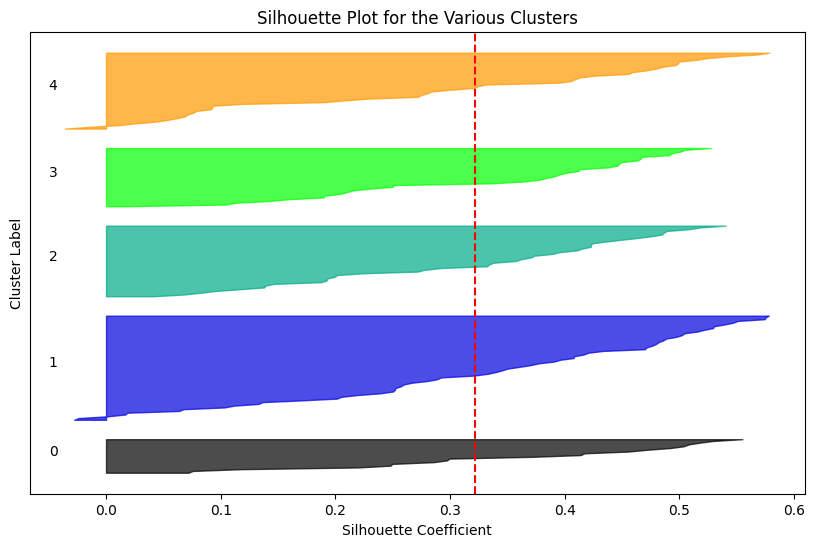

In [ ]:
import numpy as np
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples

# Silhouette analysis
silhouette_values = silhouette_samples(scaled_features, data['Cluster'])

# Create a silhouette plot
plt.figure(figsize=(10, 6))
y_lower = 10
for i in range(5):  # Adjust the range according to the number of clusters
    ith_cluster_silhouette_values = silhouette_values[data['Cluster'] == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / 5)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

plt.title("Silhouette Plot for the Various Clusters")
plt.xlabel("Silhouette Coefficient")
plt.ylabel("Cluster Label")
plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.yticks([])
plt.show()


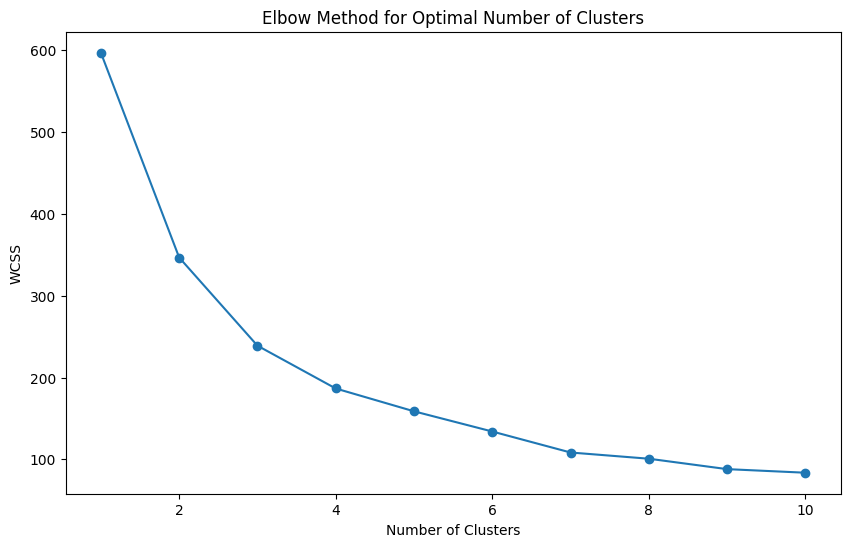

In [ ]:
# Plot the elbow method
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()


**Interpretation of Results**


**Scatter Plot of Clusters**
The scatter plot titled "Customer Segmentation" illustrates the relationship between Total Value (USD) and Quantity. The X-axis represents the total value in USD, ranging from 0 to 10,000, and the Y-axis represents the quantity, ranging from 0 to around 35. Data points are colored according to five different clusters (0 to 4), represented in the legend: Cluster 0 (Purple), Cluster 1 (Blue), Cluster 2 (Teal), Cluster 3 (Yellow), and Cluster 4 (Green). There is an upward trend, indicating that as the total value increases, the quantity also tends to increase. Different clusters show varying densities; for instance, Cluster 0 (purple) appears more concentrated at lower total values, while Clusters 3 (yellow) and 4 (green) are more prominent at higher values. This plot helps in visualizing customer segments based on their purchasing behavior, illustrating how different groups of customers might differ in terms of quantity purchased relative to their total spending.



**Pair Plot of Clusters**  The pair plot titled "Pair Plot of Clusters" visualizes the relationships between Total Value, Quantity, and Signup Date, segmented by different clusters. The plot contains multiple subplots showing pairwise relationships, with diagonal plots showing the distribution of each variable. Data points are categorized into five clusters (0 to 4), illustrated with different colors: Cluster 0 (Light pink), Cluster 1 (Pink), Cluster 2 (Light purple), Cluster 3 (Dark purple), and Cluster 4 (Dark blue). A distinct linear relationship suggests that higher total values correlate with greater quantities purchased. Different clusters exhibit varying densities, with Cluster 3 (dark purple) particularly prevalent at higher values and quantities. There are distinct trends over time, with peaks indicating periods when customers tended to sign up and make purchases, pointing to seasonal purchasing behaviors or promotional campaigns. This plot reveals how the quantity purchased changes over time, helping identify periods of peak purchasing activity among various clusters. Cluster densities vary, suggesting differing engagement levels based on signup dates. The pair plot offers insights into customer segmentation by highlighting relationships between spending, purchasing behavior, and signup activity, which can inform marketing strategies and customer retention efforts.

**Silhouette Plot**
The silhouette plot visualizes the silhouette coefficients for various clusters, helping to evaluate the clustering quality. The Y-axis lists the different cluster labels (0 through 4), and the X-axis ranges from 0.0 to 0.6, indicating the value of the silhouette coefficients. Each colored bar corresponds to a cluster, with colors representing specific clusters: Cluster 0 (gray), Cluster 1 (blue), Cluster 2 (cyan), Cluster 3 (green), and Cluster 4 (orange). The length of each bar represents the range of silhouette coefficients for that cluster, with longer bars indicating better-defined clusters. A vertical red dashed line at approximately 0.3 represents the average silhouette coefficient across all clusters, serving as a reference to evaluate the clustering quality. A value closer to 1 indicates better-defined clusters, while values around 0 suggest overlapping clusters. Overall, the plot effectively visualizes the separation of clusters, providing insight into the clustering structure.

**Elbow Method Plot**
The elbow method plot helps determine the optimal number of clusters based on the Within-Cluster Sum of Squares (WCSS). The X-axis, labeled "Number of Clusters," ranges from 1 to 10, indicating the different numbers of clusters being assessed, while the Y-axis, labeled "WCSS," shows the Within-Cluster Sum of Squares, with values ranging from just below 100 to 600. The plot shows data points for each number of clusters, with a line connecting them. There is an initial sharp decrease in WCSS as the number of clusters increases from 1 to about 4, after which the decrease becomes more gradual, suggesting diminishing returns in reducing WCSS with additional clusters. The "elbow" point around 4 clusters indicates the optimal number of clusters, where the rate of decrease in WCSS slows down significantly. This point suggests that adding more clusters beyond this may not provide significantly better clustering. Overall, the graph effectively visualizes the relationship between the number of clusters and WCSS, helping to identify the optimal cluster count for the dataset.